In [ ]:
import palantir as pa
import scanpy as sc
import pandas as pd
import os
import random
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
# warnings
import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.filterwarnings(action="ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings(
 action="ignore", module="scanpy", message="No data for colormapping"
)
plt.rcParams['font.family'] = "DejaVu Sans"  
# Inline plotting
%matplotlib inline

In [2]:
import random
import numpy as np
import os
random_seed = 1314
random.seed(random_seed)
np.random.seed(random_seed)

data_dir = "/Users/senzhu/Documents/ZJU_Project/文章写作/Single_cell_antioxidant/Manuscript Submission NC 2024.4.11/Analysis/拟时序/Rumen_epithelium"
os.chdir(data_dir)
#download_url = "https://dp-lab-data-public.s3.amazonaws.com/palantir/marrow_sample_scseq_counts.h5ad"
file_path = "AD_scanpy_use_epithelial_data.h5ad"
ad = sc.read(file_path)

ad.X.max()
sc.pp.normalize_total(ad)
pa.preprocess.log_transform(ad)
ad.X.max()
sc.pp.highly_variable_genes(ad, n_top_genes=2000)
## pca
sc.pp.pca(ad)

In [3]:
dm_res = pa.utils.run_diffusion_maps(ad, n_components=5)
ms_data = pa.utils.determine_multiscale_space(ad)
ms_data  #

/Users/senzhu/opt/anaconda3/envs/palantir_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0         1
sc_CAU_sc1_AAACGCTCACTGGATT-1   2.350140 -1.019933
sc_CAU_sc1_AAAGGGCTCCTCAGGG-1   2.360983 -0.998856
sc_CAU_sc1_AAAGTGACATGAATAG-1   1.599214 -1.107351
sc_CAU_sc1_AAGCGAGAGTCTGCAT-1  -2.713045  0.213189
sc_CAU_sc1_AATAGAGGTACGTACT-1   2.329763 -1.073202
...                                  ...       ...
Public_sc2_TTGGATGAGCATTTCG-1 -14.995287  0.174241
Public_sc2_TTTACCAGTACGTGAG-1  -6.241271 -0.460073
Public_sc2_TTTCATGCAAATAAGC-1 -12.412883 -0.017069
Public_sc2_TTTCGATGTTAGGAGC-1  -6.090465 -0.470938
Public_sc2_TTTGACTAGGGATCGT-1  -6.176458 -0.465642

[12420 rows x 2 columns]

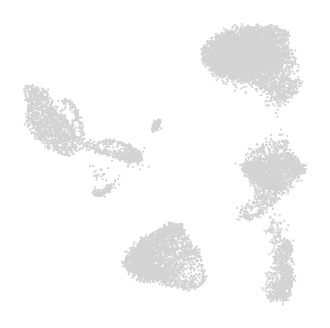

In [4]:
sc.pp.neighbors(ad)
sc.tl.umap(ad)
sc.pl.embedding(
    ad,
    basis="umap",
    frameon=False,
)

In [5]:
umap_coordinates = ad.obsm['X_umap']
max_idx = umap_coordinates[:, 0].argmax() 
cell_name = ad.obs_names[max_idx]
print(f"The cell with the farthest right position is: {cell_name}")


The cell with the farthest right position is: sc_CAU_sc3_AAAGGTATCCTGTTGC-1


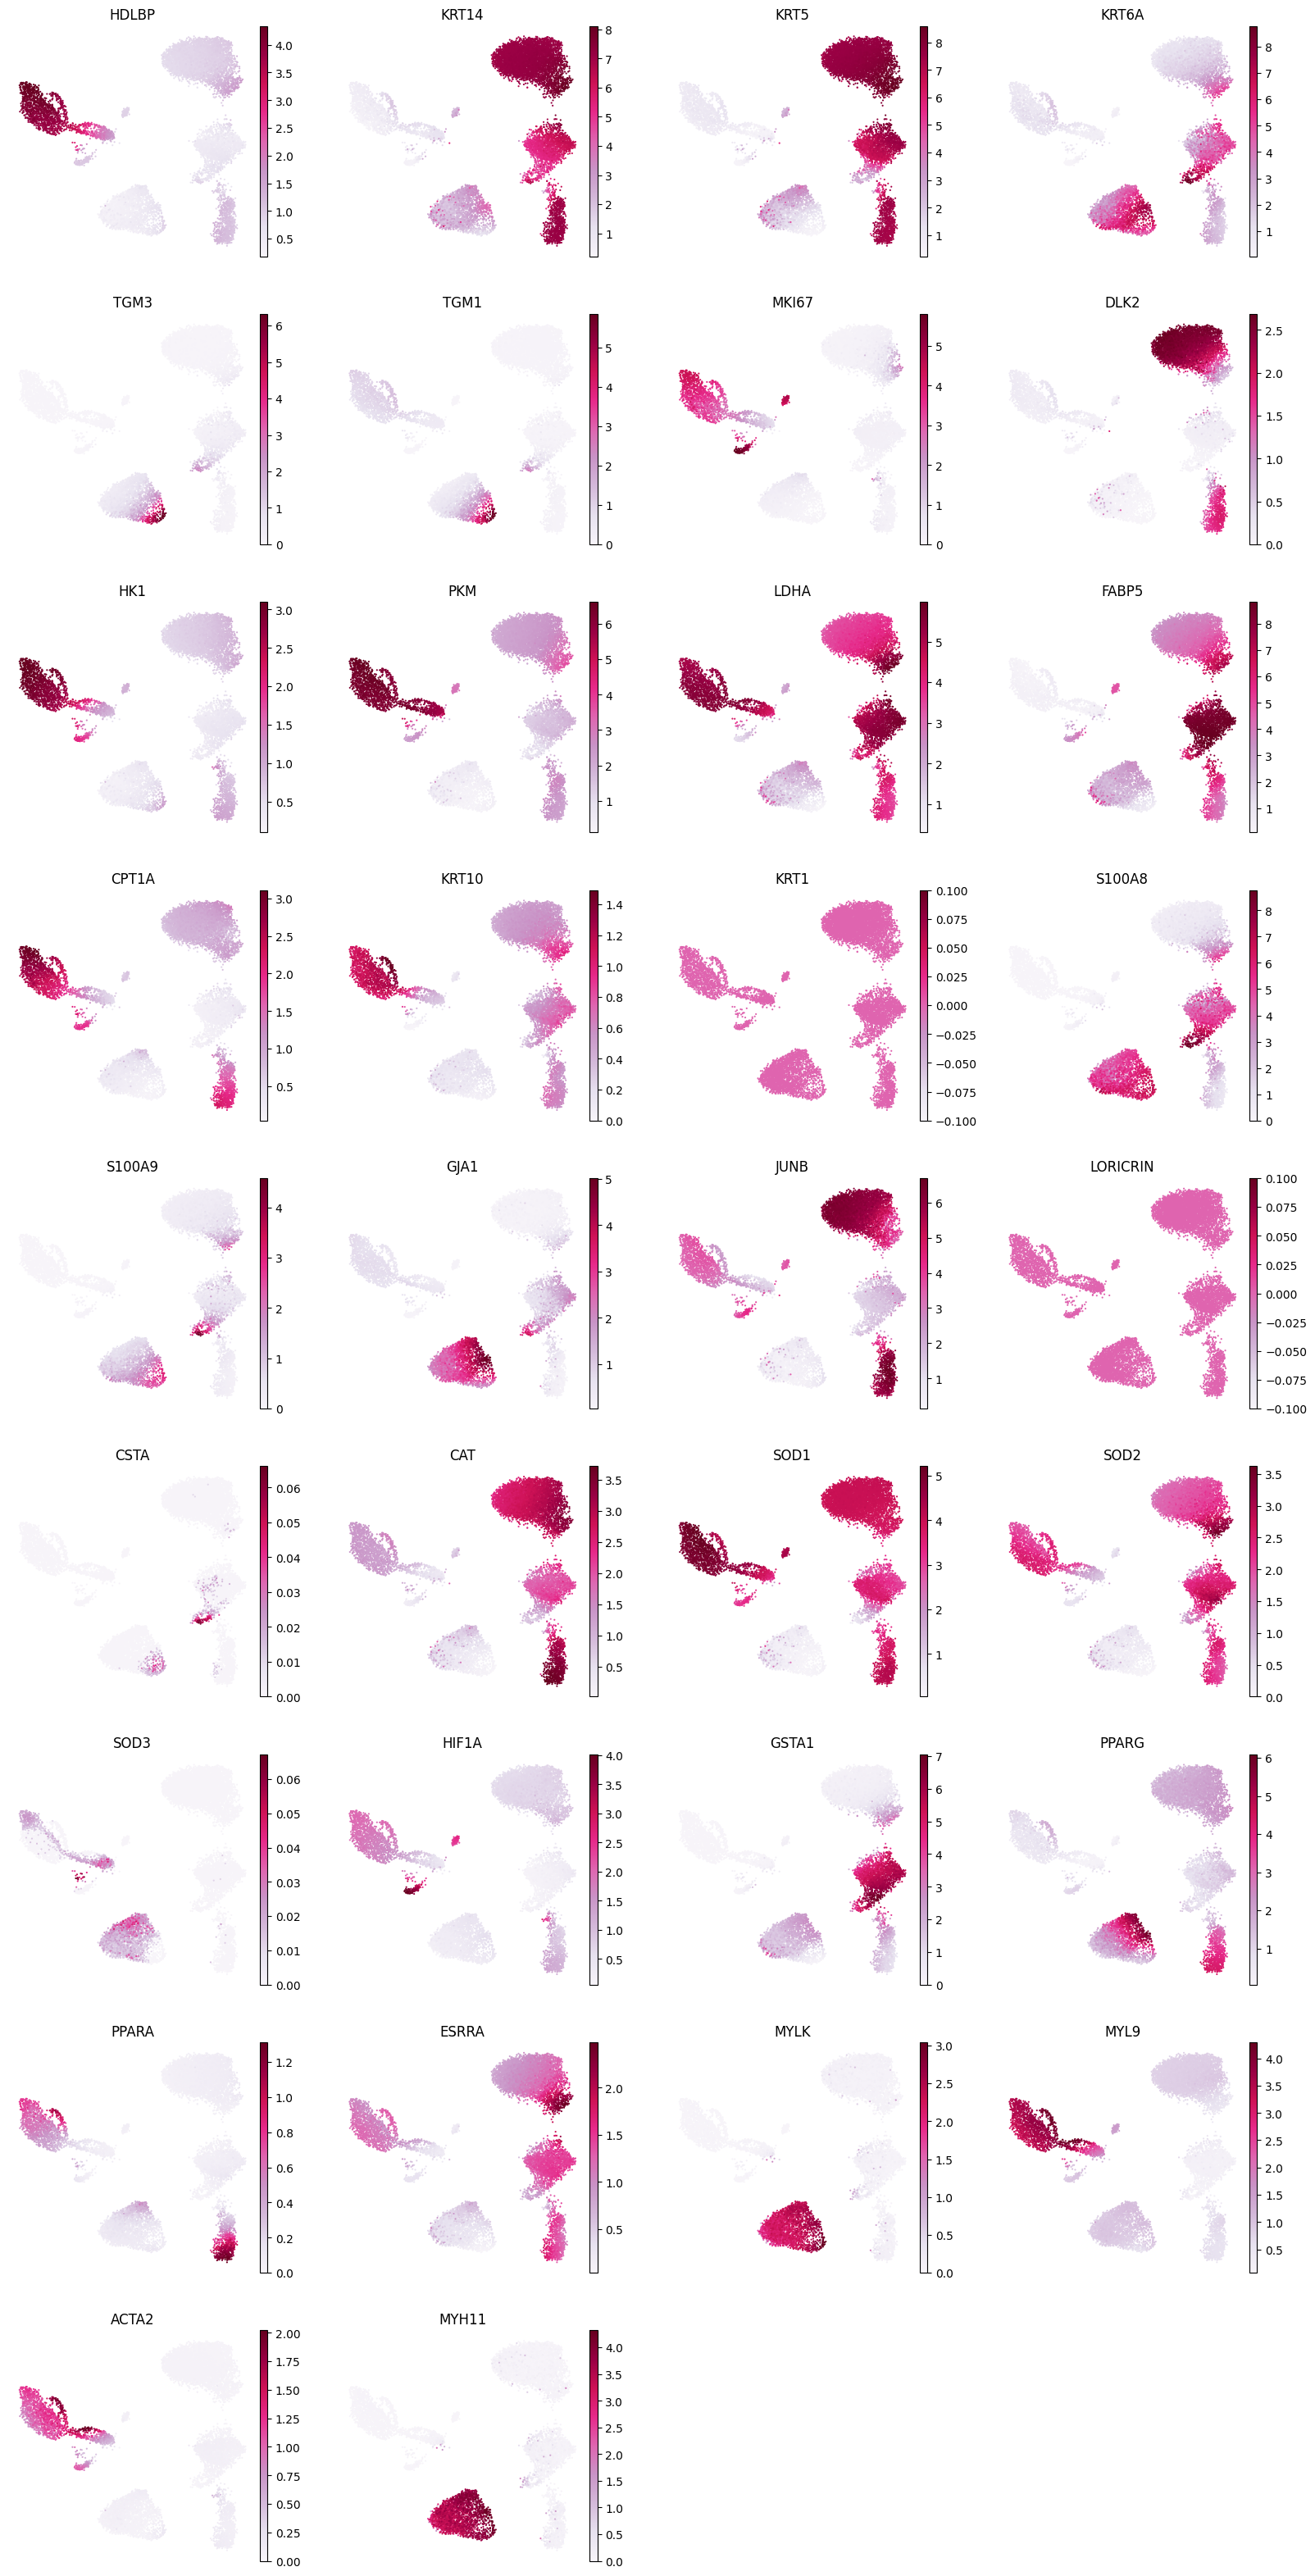

In [6]:
imputed_X = pa.utils.run_magic_imputation(ad)
sc.pl.embedding(
 ad,
 basis="umap",
 layer="MAGIC_imputed_data",
 color=['HDLBP',"KRT14","KRT5", "KRT6A",'TGM3','TGM1','MKI67','DLK2','HK1','PKM','LDHA','FABP5','CPT1A','KRT10','KRT1','S100A8','S100A9',"GJA1",'JUNB','LORICRIN','CSTA','CAT',
        'SOD1','SOD2','SOD3',"HIF1A","GSTA1","PPARG",'PPARA','ESRRA','MYLK', 'MYL9','ACTA2','MYH11'],   ## HSC gene CD34, myeloid gene髓系细胞 MPO and erythroid precursor                                              #  gene 红系GATA1 and dendritic cell 树突细胞 gene IRF8.
 frameon=False,
 cmap='PuRd'
)
plt.show()

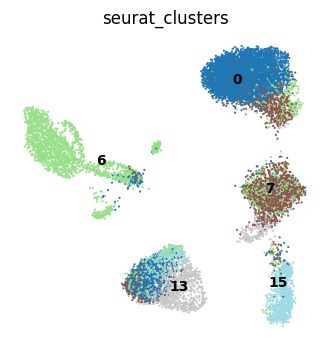

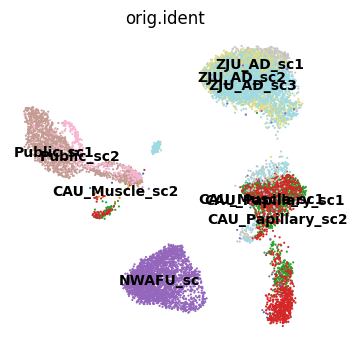

In [7]:
ad.obs['seurat_clusters'] = ad.obs['seurat_clusters'].astype('category')
sc.pl.embedding(
    ad,
    basis="umap",
    color="seurat_clusters",        
    frameon=False,              
    legend_loc='on data',        
    palette='tab20'              
)
sc.pl.embedding(
    ad,
    basis="umap",
    color="orig.ident",         
    frameon=False,               
    legend_loc='on data',       
    palette='tab20'             
)


In [8]:
# check the cell number
num_cells, num_genes = ad.shape

print(f"Number of cells: {num_cells}")
print(f"Number of genes: {num_genes}")


Number of cells: 12420
Number of genes: 20912


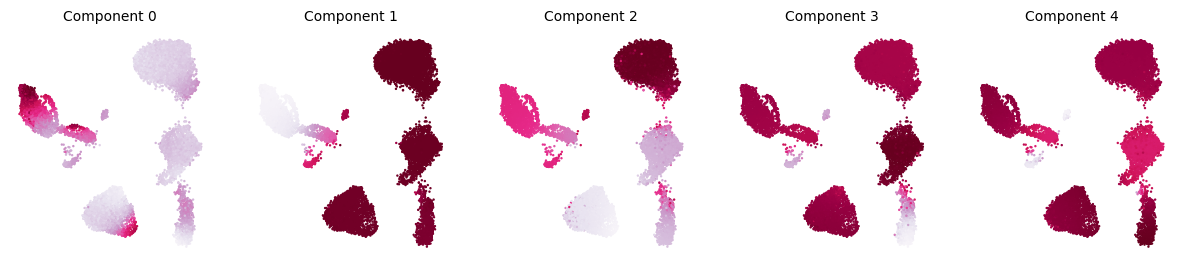

In [9]:

pa.plot.plot_diffusion_components(ad, cmap='PuRd')
plt.show()

In [10]:
#Selecet the root and end
import scanpy as sc
import pandas as pd
import plotly.express as px


# Create a dataframe for Plotly
df = pd.DataFrame(ad.obsm['X_umap'], columns=['UMAP1', 'UMAP2'])
df['cell_type'] = ad.obs['seurat_clusters']  # Now 'louvain' exists in obs

# Plot UMAP with Plotly for interactive selection
fig = px.scatter(df, x='UMAP1', y='UMAP2', color='cell_type', hover_name=ad.obs_names)

fig.show()


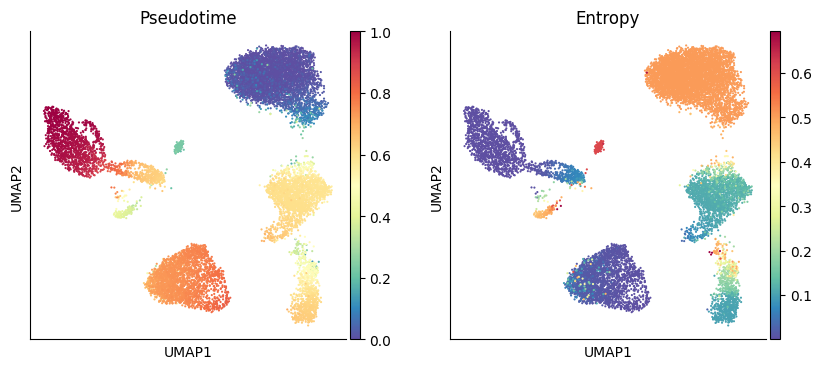

In [12]:
ad.obs['Pseudotime'] = pr_res.pseudotime
ad.obs["Entropy"] = pr_res.entropy
sc.pl.embedding(ad, basis="umap", color=['Pseudotime', 'Entropy'])


In [13]:
start_cell = 'sc_ZJU_AD_sc1_CATTGAGTCCGAGCTG-1'   
terminal_states = pd.Series(
["1","2"],
index=['Public_sc1_ACCACAAAGGCCGCTT-1', 'sc_NWAFU_sc_./sn_MidRumen_2_ddqcR_QC.RDS_CELL4731_N1'])
pr_res = pa.core.run_palantir(
 ad, 
 start_cell, 
 num_waypoints=500, 
 #terminal_states=terminal_states,
 n_jobs=16
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.004329800605773926 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.11677905321121215 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [15]:
# 将 'palantir_fate_probabilities' 复制为 'branch_masks'
#ad.obsm['branch_masks'] = ad.obsm['palantir_fate_probabilities']
ad.obs['palantir_pseudotime'] = ad.obs['Pseudotime']
ad.obs['palantir_entropy'] = ad.obs['Entropy']
ad.obsm['palantir_entropy'] = ad.obs['Entropy']

#print(ad.obsm.keys()) 
masks = pa.presults.select_branch_cells(ad, q=.01, eps=.01)

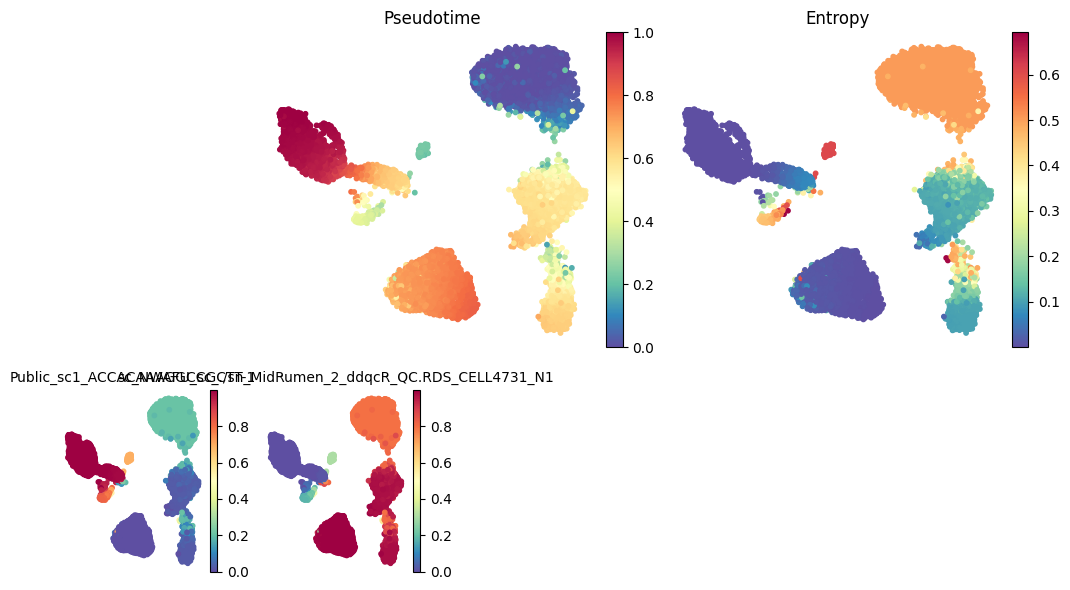

In [16]:
pa.plot.plot_palantir_results(ad, s=10)
plt.show()

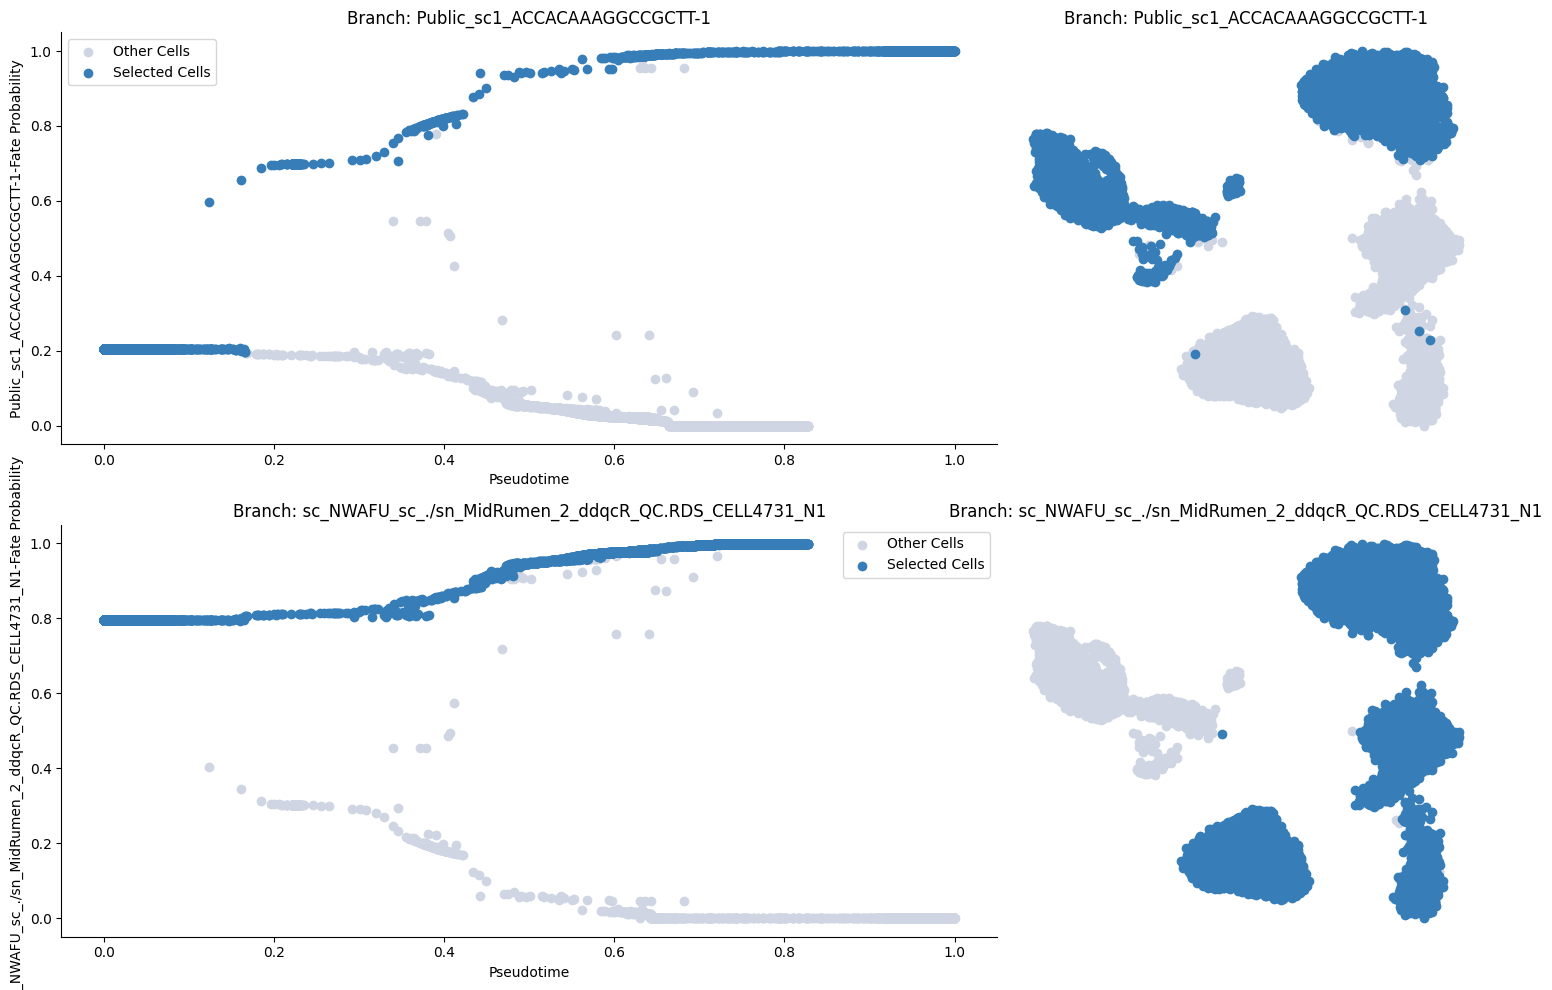

In [17]:
pa.plot.plot_branch_selection(ad)
plt.show()
#pa.plot.plot_trajectory(ad, "1")
#plt.show()
#pa.plot.plot_trajectory(ad, "2")
#plt.show()

[2025-03-31 23:27:00,926] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (6,987) and rank = 1.0.
[2025-03-31 23:27:00,926] [INFO    ] Using covariance function Matern52(ls=1.3830706596374511).
[2025-03-31 23:27:00,944] [INFO    ] Computing 50 landmarks with k-means clustering.
[2025-03-31 23:27:02,273] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (10,307) and rank = 1.0.
[2025-03-31 23:27:02,274] [INFO    ] Using covariance function Matern52(ls=1.3830706596374511).
[2025-03-31 23:27:02,286] [INFO    ] Computing 50 landmarks with k-means clustering.


<Axes: title={'center': 'Branch: sc_NWAFU_sc_./sn_MidRumen_2_ddqcR_QC.RDS_CELL4731_N1'}, xlabel='UMAP1', ylabel='UMAP2'>

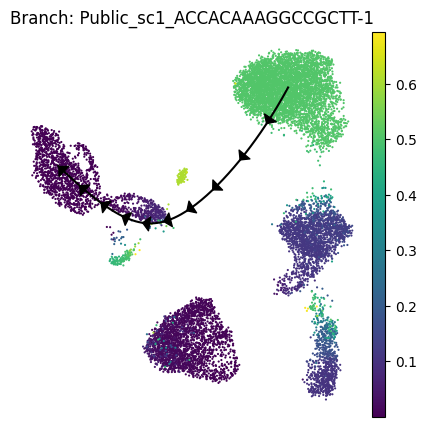

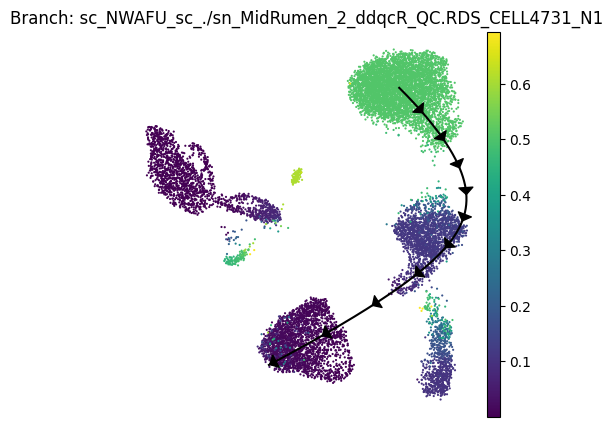

In [18]:
# Assuming you already have an AnnData object 'ad'
# Run Palantir (assuming diffusion maps have already been computed)
#['Public_sc1_ACCACAAAGGCCGCTT-1', 'sc_NWAFU_sc_./sn_MidRumen_2_ddqcR_QC.RDS_CELL4731_N1']
# Plot trajectory for a specific branch
pa.plot.plot_trajectory(
    ad, #'Public_sc1_ACCACAAAGGCCGCTT-1', 'sc_NWAFU_sc_./sn_MidRumen_2_ddqcR_QC.RDS_CELL4731_N1'
    branch = 'Public_sc1_ACCACAAAGGCCGCTT-1',  # Branch 1   
    cell_color="palantir_entropy",  # Coloring cells by palantir_entropy
    n_arrows=10,  # Number of arrows on the trajectory
    color="black",  # Color of the arrows
    scanpy_kwargs=dict(cmap="viridis"),  # Colormap for the trajectory
    arrowprops=dict(arrowstyle="-|>,head_length=.5,head_width=.5"),  # Arrow style
)

pa.plot.plot_trajectory(
    ad,
    "sc_NWAFU_sc_./sn_MidRumen_2_ddqcR_QC.RDS_CELL4731_N1",
    cell_color="palantir_entropy",
    n_arrows=10,
    color="black",
    scanpy_kwargs=dict(cmap="viridis"),
    arrowprops=dict(arrowstyle="-|>,head_length=.5,head_width=.5"),
)

In [19]:
gene_trends = pa.presults.compute_gene_trends(
    ad,
    expression_key="MAGIC_imputed_data",
)

Public_sc1_ACCACAAAGGCCGCTT-1
[2025-03-31 23:27:08,800] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (6,987) and rank = 1.0.
[2025-03-31 23:27:08,801] [INFO    ] Using covariance function Matern52(ls=1.0).
sc_NWAFU_sc_./sn_MidRumen_2_ddqcR_QC.RDS_CELL4731_N1
[2025-03-31 23:27:11,881] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (10,307) and rank = 1.0.
[2025-03-31 23:27:11,882] [INFO    ] Using covariance function Matern52(ls=1.0).


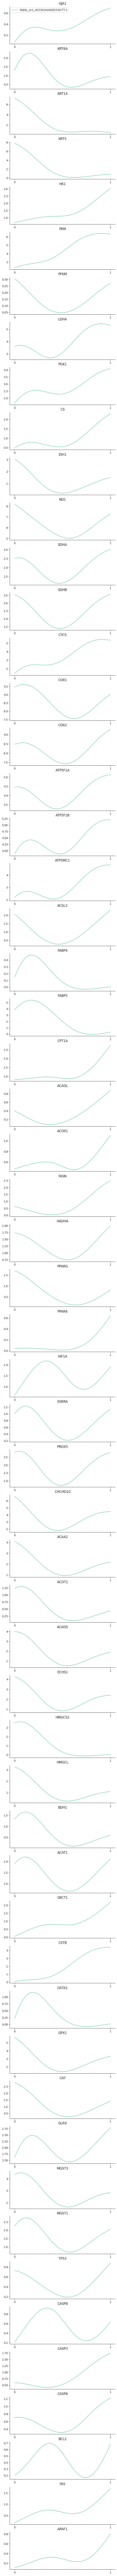

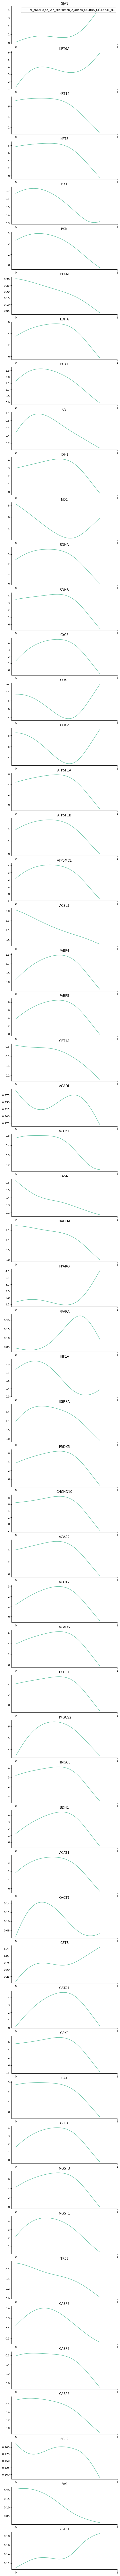

In [ ]:
# Define a list of genes related to various biological processes
genes = [
    "GJA1", "KRT6A", "KRT14", "KRT5",  # Keratin-related genes
    "HK1", "PFK1", "PKM", "PFKM",  # Glycolysis-related genes
    "LDHA", "PGK1",  # Anaerobic metabolism
    "CS", "IDH1",  # TCA cycle (tricarboxylic acid cycle)
    "ND1", "SDHA", "SDHB", "CYCS", "COX1", "COX2", "ATP5F1A", "ATP5F1B", "ATP5MC1",  # Mitochondrial oxidative phosphorylation
    "ACSL3", "FABP4", "FABP5", "CPT1A", "ACADL", "ACOX1", "FASN", "HADHA",  # Fatty acid metabolism
    "PPARG", "PPARA", "HIF1A", "ESRRA",  # Transcription factors regulating metabolism
    "PRDX5", "CHCHD10", "ASF2", "ACAA2", "ACOT2", "ACADS", "ECHS1",  # Mitochondrial function and antioxidant defense
    "HMGCS2", "HMGCL", "BDH1", "ACAT1", "OXCT1",  # Ketone body metabolism
    "CSTB", "GSTA1", "GPX1", "CAT", "GLRX", "MGST3", "MGST1",  # Antioxidant response genes
    "TP53", "CASP8", "CASP3", "CASP6", "BCL2", "FAS", "APAF1"  # Apoptosis-related genes
]

# Retrieve the list of genes available in the single-cell data matrix
cell_genes = ad.var_names.tolist()

# Filter the list to keep only genes that are present in the data
filtered_genes = [gene for gene in genes if gene in cell_genes]

# Define branch names for visualization
branch_1 = ['Public_sc1_ACCACAAAGGCCGCTT-1']
branch_2 = ['sc_NWAFU_sc_./sn_MidRumen_2_ddqcR_QC.RDS_CELL4731_N1']

# Plot gene expression trends along pseudotime for the first branch
pa.plot.plot_gene_trends(ad, genes=filtered_genes, branch_names=branch_1)
plt.show()

# Plot gene expression trends along pseudotime for the second branch
pa.plot.plot_gene_trends(ad, genes=filtered_genes, branch_names=branch_2)
plt.show()


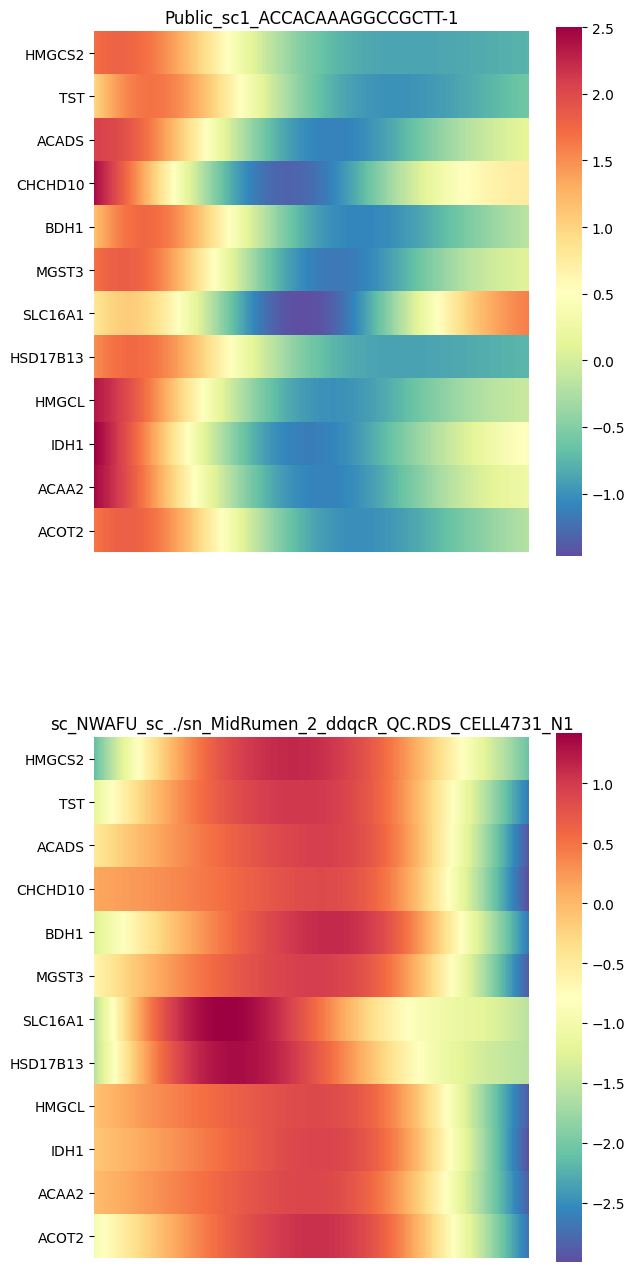

In [30]:
pa.plot.plot_gene_trend_heatmaps(ad, ['HMGCS2','TST','ACADS','CHCHD10','BDH1','MGST3','SLC16A1','HSD17B13','HMGCL','IDH1','ACAA2','ACOT2'])   

plt.show()

In [ ]:
# Print the columns of the `obs` (observations) attribute of the AnnData object `ad`
# This will show the metadata columns associated with the cells
print(ad.obs.columns)

# Save the `obs` DataFrame to a CSV file. This file will contain the observation data, including metadata.
# The `index=True` ensures that the index (cell IDs) is saved as well
ad.obs.to_csv('AD_afterrun_palantir_file.csv', index=True)

import pickle

# Save the entire AnnData object (`ad`) as a pickle file.
# This allows you to store the object and load it later without having to recompute the analysis.
with open('AD_scanpy_use_epithelial_data.pkl', 'wb') as f:
    pickle.dump(ad, f)